In [122]:
#import train data using pandas
#key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count

import pandas as pd
import numpy as np
from pyproj import Geod
from scipy import stats
import seaborn
import matplotlib.pyplot as plt
import math

#float_cols = ['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
#float32_cols = {c: np.float32 for c in float_cols}

taxi_train_df = pd.read_csv('train-small.csv',  error_bad_lines=False, usecols=range(1,8))
print("Loaded %d rows" % len(taxi_train_df))

Loaded 2500 rows


In [123]:
#clean the data



num_cols = ['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
int_cols = ['passenger_count']
date_cols = ['pickup_datetime']

#filter out rows where numerical values are not numerical
taxi_train_df[num_cols] = taxi_train_df[num_cols].apply(pd.to_numeric, errors='coerce').astype(np.float32)

#filter out invalid dates
taxi_train_df[date_cols] = taxi_train_df[date_cols].apply(pd.to_datetime, errors='coerce')

#filter out latitides==0 or longitudes=0
taxi_train_df.loc[taxi_train_df['pickup_longitude']==0, 'pickup_longitude'] = np.nan
taxi_train_df.loc[taxi_train_df['pickup_latitude']==0, 'pickup_latitude'] = np.nan
taxi_train_df.loc[taxi_train_df['dropoff_longitude']==0, 'dropoff_longitude'] = np.nan
taxi_train_df.loc[taxi_train_df['dropoff_latitude']==0, 'dropoff_latitude'] = np.nan
taxi_train_df.loc[taxi_train_df['passenger_count']>6, 'passenger_count'] = np.nan

#drop NaN values
taxi_train_df = taxi_train_df.dropna()

#taxi_train_df.pickup_longitude = taxi_train_df.pickup_longitude.round(3)
#taxi_train_df['pickup_latitude'] = taxi_train_df['pickup_latitude'].round(6)
'''taxi_train_df.style.format({
    'pickup_longitude': '{:,.1f}'.format,
    'dropoff_longitude': '{:,.3f}'.format,
})'''

print(taxi_train_df.dtypes)

#filter out rows where pick_lat==drop_lat and pick_long==drop_lat
#taxi_train_df = [row for index,row in taxi_train_df.iterrows() if row['pickup_latitude'] != row['dropoff_latitude'] or row['pickup_longitude'] != row['dropoff_longitude'] or row['pickup_latitude']==0 or row['dropoff_latitude'] == 0 or row['pickup_longitude']==0 or row['dropoff_longitude']==0]



print(len(taxi_train_df))
print(taxi_train_df.values[0])


fare_amount                 float32
pickup_datetime      datetime64[ns]
pickup_longitude            float32
pickup_latitude             float32
dropoff_longitude           float32
dropoff_latitude            float32
passenger_count             float32
dtype: object
2449
[4.5 Timestamp('2009-06-15 17:26:21') -73.84431457519531
 40.721317291259766 -73.84161376953125 40.712276458740234 1.0]


In [124]:
wgs84_geod = Geod(ellps='WGS84')

#get euclidean distance between 2 lat long points
def get_euclidean_distance(row):
  az12,az21,dist = wgs84_geod.inv(row['pickup_longitude'],row['pickup_latitude'],row['dropoff_longitude'],row['dropoff_latitude'])
  return dist

#get manhattan distance between 2 lat long points
def get_manhattan_distance(row):
    return abs(row['pickup_longitude']-row['dropoff_longitude']) + abs(row['pickup_latitude']-row['dropoff_latitude'])

#get hour and minute distance between 2 lat long points
def get_hour_minute(row):
    return int(row['pickup_datetime'].hour)*100 + int(row['pickup_datetime'].minute)

def get_date_month(row):
    return int(row['pickup_datetime'].month)*100 + int(row['pickup_datetime'].day)


taxi_train_df['euclidean_dist'] = taxi_train_df.apply (lambda row: get_euclidean_distance(row),axis=1)
taxi_train_df['manhattan_dist'] = taxi_train_df.apply (lambda row: get_manhattan_distance(row),axis=1)
taxi_train_df['time_of_day'] = taxi_train_df.apply (lambda row: get_hour_minute(row),axis=1)
taxi_train_df['day_of_year'] = taxi_train_df.apply (lambda row: get_date_month(row),axis=1)



In [125]:
#2.1
print("Pearson correlation between fare amount and euclidean distance: %f" % stats.pearsonr(taxi_train_df.fare_amount, taxi_train_df.euclidean_dist)[0])

#2.2
print("Pearson correlation between time of day and distance travelled: %f" % stats.pearsonr(taxi_train_df.time_of_day, taxi_train_df.manhattan_dist)[0])

#2.3
print("Pearson correlation between fare amount and manhattan distance: %f" % stats.pearsonr(taxi_train_df.time_of_day, taxi_train_df.fare_amount)[0])


Pearson correlation between fare amount and euclidean distance: 0.640922
Pearson correlation between time of day and distance travelled: -0.020411
Pearson correlation between fare amount and manhattan distance: -0.028925


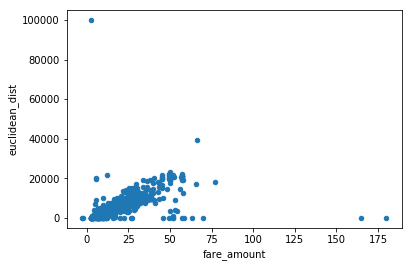

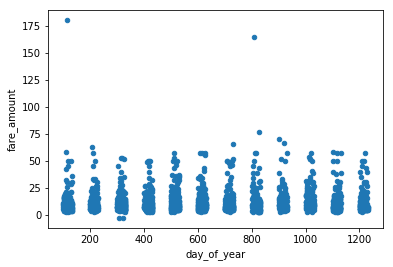

In [126]:
#3.1.1 Plot between taxi fare and distance travelled
plot = taxi_train_df.plot.scatter('fare_amount', 'euclidean_dist')
plot = taxi_train_df.plot.scatter('day_of_year', 'fare_amount')

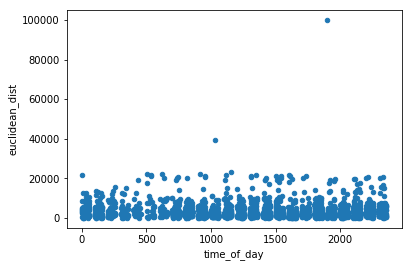

In [127]:
#3.2.1 Plot between time of day and distance travelled
plot = taxi_train_df.plot.scatter('time_of_day', 'euclidean_dist')

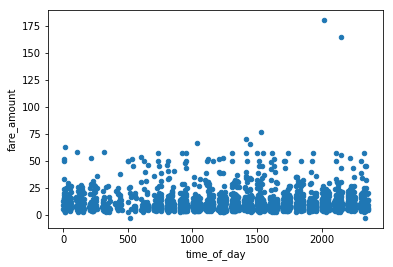

In [128]:
#3.3.1 Plot between time of day and distance travelled
plot = taxi_train_df.plot.scatter('time_of_day', 'fare_amount')